# Stock Market Prediction using Numerical and Textual Analysis 

### Mallikarjun Jamadarkhani
#### jamadarkhani29.maj@gmail.com
#### https://www.linkedin.com/in/mallikarjun-jamadarkhani-950929101/


# 1 Import libraries

In [1]:
# download nltk if not installed previously
# nltk.download('vader_lexicon')
# download yfinance

In [ ]:
pip install yfinance --upgrade --no-cache-dir

In [1]:
# importing libraries
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
nltk.download('vader_lexicon')

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

import yfinance as yf

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# 2 Downloading Datasets | Stock Price Data | Stock News Headlines Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# reading the datasets into pandas
stock_price = yf.download('^BSESN', start='2015-01-01', end='2020-12-31')
stock_headlines = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_Datasets/india-news-headlines.csv')

[*********************100%***********************]  1 of 1 completed


In [4]:
# displaying stock price dataset
stock_price.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400
2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200
2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100
2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200
2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200


In [5]:
# displaying stock news headlines dataset
stock_headlines.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


# 3 Feature Engineering


In [6]:
# displaying number of records in both stock_price and stock_headlines datasets
len(stock_price), len(stock_headlines)

(1473, 3424067)

In [7]:
# checking for null values in both the datasets
stock_price.isna().any(), stock_headlines.isna().any()

(Open         False
 High         False
 Low          False
 Close        False
 Adj Close    False
 Volume       False
 dtype: bool, publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool)

### 3.1 Stock Price Data

In [8]:
# dropping duplicates
stock_price = stock_price.drop_duplicates()

# filtering the important columns required
stock_price = stock_price.filter(['Close', 'Open', 'High', 'Low', 'Volume'])

# sorting the data according to the index i.e 'Date'
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,Open,High,Low,Volume
Date,,,,,
2015-01-02,27887.900391,27521.279297,27937.470703,27519.259766,7400
2015-01-05,27842.320312,27978.429688,28064.490234,27786.849609,9200
2015-01-06,26987.460938,27694.230469,27698.929688,26937.060547,14100
2015-01-07,26908.820312,26983.429688,27051.599609,26776.119141,12200
2015-01-08,27274.710938,27178.769531,27316.410156,27101.939453,8200
...,...,...,...,...,...
2020-12-23,46444.179688,46072.300781,46513.320312,45899.101562,10500
2020-12-24,46973.539062,46743.488281,47053.398438,46539.019531,13700
2020-12-28,47353.750000,47153.589844,47406.718750,47148.238281,9600


### 3.2 Stock News Headlines Data

In [9]:
# dropping duplicates
stock_headlines = stock_headlines.drop_duplicates()

# coverting the datatype of column 'Date' from type string to type 'datetime'
stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()

# filtering the important columns required
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])

# grouping the news headlines according to 'Date'
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting column 'Date' as the index column
stock_headlines.set_index('publish_date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
2020-12-28,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,Man recovers charred remains of 'thief' from h...


### 3.3 Combined Stock Data

In [10]:
# concatenating the datasets stock_price and stock_headlines
stock_data = pd.concat([stock_price, stock_headlines], axis=1)

# dropping the null values if any
stock_data.dropna(axis=0, inplace=True)

# displaying the combined stock_data
stock_data

,Close,Open,High,Low,Volume,headline_text
2015-01-02,27887.900391,27521.279297,27937.470703,27519.259766,7400.0,"Drink smart with these party tips,How to say s..."
2015-01-05,27842.320312,27978.429688,28064.490234,27786.849609,9200.0,"Recipe: Strawberry cupcakes,Recipe: Kaju jeera..."
2015-01-06,26987.460938,27694.230469,27698.929688,26937.060547,14100.0,"Turn to gardening for happiness,Teeth jeweller..."
2015-01-07,26908.820312,26983.429688,27051.599609,26776.119141,12200.0,"Can ex-lovers be friends?,Is water diet bad fo..."
2015-01-08,27274.710938,27178.769531,27316.410156,27101.939453,8200.0,"How to do a home manicure,Recipe: Spiced beetr..."
...,...,...,...,...,...,...
2020-12-23,46444.179688,46072.300781,46513.320312,45899.101562,10500.0,"Sawmill in Makarpura GIDC gutted; none hurt,Ci..."
2020-12-24,46973.539062,46743.488281,47053.398438,46539.019531,13700.0,How to set the mood for sex during cold winter...
2020-12-28,47353.750000,47153.589844,47406.718750,47148.238281,9600.0,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,47613.078125,47466.621094,47714.550781,47361.898438,12800.0,Man recovers charred remains of 'thief' from h...


## 3.4 Calculating Sentiment Scores

In [11]:
# adding empty sentiment columns to stock_data for later calculation
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2015-01-02,27887.900391,27521.279297,27937.470703,27519.259766,7400.0,"Drink smart with these party tips,How to say s...",,,,
2015-01-05,27842.320312,27978.429688,28064.490234,27786.849609,9200.0,"Recipe: Strawberry cupcakes,Recipe: Kaju jeera...",,,,
2015-01-06,26987.460938,27694.230469,27698.929688,26937.060547,14100.0,"Turn to gardening for happiness,Teeth jeweller...",,,,
2015-01-07,26908.820312,26983.429688,27051.599609,26776.119141,12200.0,"Can ex-lovers be friends?,Is water diet bad fo...",,,,
2015-01-08,27274.710938,27178.769531,27316.410156,27101.939453,8200.0,"How to do a home manicure,Recipe: Spiced beetr...",,,,


In [12]:
# importing requires libraries to analyze the sentiments
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

# instantiating the Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# calculating sentiment scores
stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])

# displaying the stock data
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2015-01-02,27887.900391,27521.279297,27937.470703,27519.259766,7400.0,"Drink smart with these party tips,How to say s...",-0.9995,0.130,0.767,0.102
2015-01-05,27842.320312,27978.429688,28064.490234,27786.849609,9200.0,"Recipe: Strawberry cupcakes,Recipe: Kaju jeera...",-0.9972,0.117,0.776,0.107
2015-01-06,26987.460938,27694.230469,27698.929688,26937.060547,14100.0,"Turn to gardening for happiness,Teeth jeweller...",-0.9994,0.097,0.838,0.065
2015-01-07,26908.820312,26983.429688,27051.599609,26776.119141,12200.0,"Can ex-lovers be friends?,Is water diet bad fo...",-0.9999,0.146,0.775,0.079
2015-01-08,27274.710938,27178.769531,27316.410156,27101.939453,8200.0,"How to do a home manicure,Recipe: Spiced beetr...",-0.9999,0.131,0.803,0.066


# 4 Finalising Stock Data and writing to Disk

In [13]:
# dropping the 'headline_text' which is unwanted now
stock_data.drop(['headline_text'], inplace=True, axis=1)

# rearranging the columns of the whole stock_data
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# displaying the final stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2015-01-02,27887.900391,-0.9995,0.130,0.767,0.102,27521.279297,27937.470703,27519.259766,7400.0
2015-01-05,27842.320312,-0.9972,0.117,0.776,0.107,27978.429688,28064.490234,27786.849609,9200.0
2015-01-06,26987.460938,-0.9994,0.097,0.838,0.065,27694.230469,27698.929688,26937.060547,14100.0
2015-01-07,26908.820312,-0.9999,0.146,0.775,0.079,26983.429688,27051.599609,26776.119141,12200.0
2015-01-08,27274.710938,-0.9999,0.131,0.803,0.066,27178.769531,27316.410156,27101.939453,8200.0


In [14]:
# writing the prepared stock_data to disk
stock_data.to_csv('stock_data.csv')

# 5 Reading Stock Data 

In [15]:
# re-reading the stock_data into pandas dataframe
stock_data = pd.read_csv('stock_data.csv', index_col = False)

# renaming the column
stock_data.rename(columns={'Unnamed: 0':'Date'}, inplace = True)

# setting the column 'Date' as the index column
stock_data.set_index('Date', inplace=True)

# displaying the stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2015-01-02,27887.900391,-0.9995,0.130,0.767,0.102,27521.279297,27937.470703,27519.259766,7400.0
2015-01-05,27842.320312,-0.9972,0.117,0.776,0.107,27978.429688,28064.490234,27786.849609,9200.0
2015-01-06,26987.460938,-0.9994,0.097,0.838,0.065,27694.230469,27698.929688,26937.060547,14100.0
2015-01-07,26908.820312,-0.9999,0.146,0.775,0.079,26983.429688,27051.599609,26776.119141,12200.0
2015-01-08,27274.710938,-0.9999,0.131,0.803,0.066,27178.769531,27316.410156,27101.939453,8200.0


# 6 Feature Engineering of Stock Data

In [16]:
# displaying the shape i.e. number of rows and columns of stock_data
stock_data.shape

(1473, 9)

In [17]:
# checking for null values
stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [18]:
# displaying stock_data statistics
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1.473000e+03
mean,32710.765247,-0.954948,0.130775,0.782713,0.086538,32756.475177,32910.536967,32523.740065,2.303866e+05
std,5365.944383,0.289243,0.017613,0.022736,0.014162,5370.950712,5384.280650,5339.478124,1.942206e+06
min,22951.830078,-1.000000,0.068000,0.730000,0.044000,23060.390625,23142.960938,22494.609375,2.500000e+03
25%,27876.609375,-0.999900,0.120000,0.766000,0.077000,27885.359375,28028.980469,27716.779297,1.020000e+04
50%,32597.179688,-0.999800,0.131000,0.779000,0.086000,32619.259766,32748.140625,32445.429688,1.340000e+04
75%,37118.218750,-0.999600,0.142000,0.796000,0.096000,37222.261719,37406.550781,36898.800781,1.850000e+04
max,47746.218750,0.999900,0.199000,0.869000,0.158000,47789.031250,47807.851562,47361.898438,3.181510e+07


In [19]:
# displaying stock_data information
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1473 entries, 2015-01-02 to 2020-12-30
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     1473 non-null   float64
 1   compound  1473 non-null   float64
 2   negative  1473 non-null   float64
 3   neutral   1473 non-null   float64
 4   positive  1473 non-null   float64
 5   Open      1473 non-null   float64
 6   High      1473 non-null   float64
 7   Low       1473 non-null   float64
 8   Volume    1473 non-null   float64
dtypes: float64(9)
memory usage: 115.1+ KB


# 7 EDA of Stock Data

Text(0, 0.5, 'Close Price ($)')

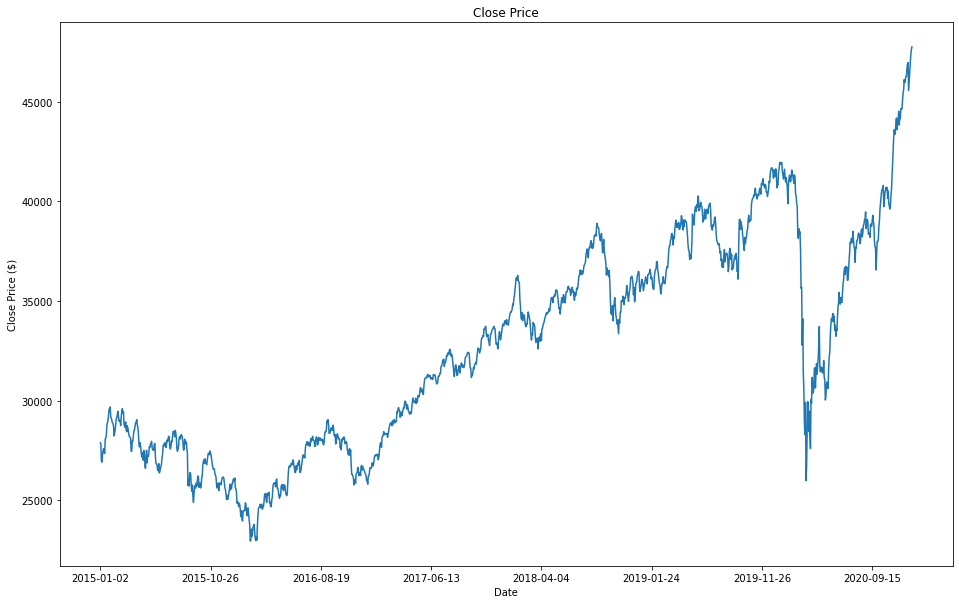

In [20]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting close price
stock_data['Close'].plot()

# setting plot title, x and y labels
plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price ($)')

In [21]:
# calculating 7 day rolling mean
stock_data.rolling(7).mean().head(20)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-12,27420.694754,-0.714000,0.122429,0.788429,0.089143,27469.169643,27599.604353,27223.514230,9957.142857
2015-01-13,27354.670480,-0.713957,0.121429,0.789143,0.089571,27482.066964,27561.421317,27195.702846,10014.285714
2015-01-14,27283.884766,-0.714300,0.122857,0.788429,0.088857,27404.025670,27482.608538,27112.331473,10157.142857


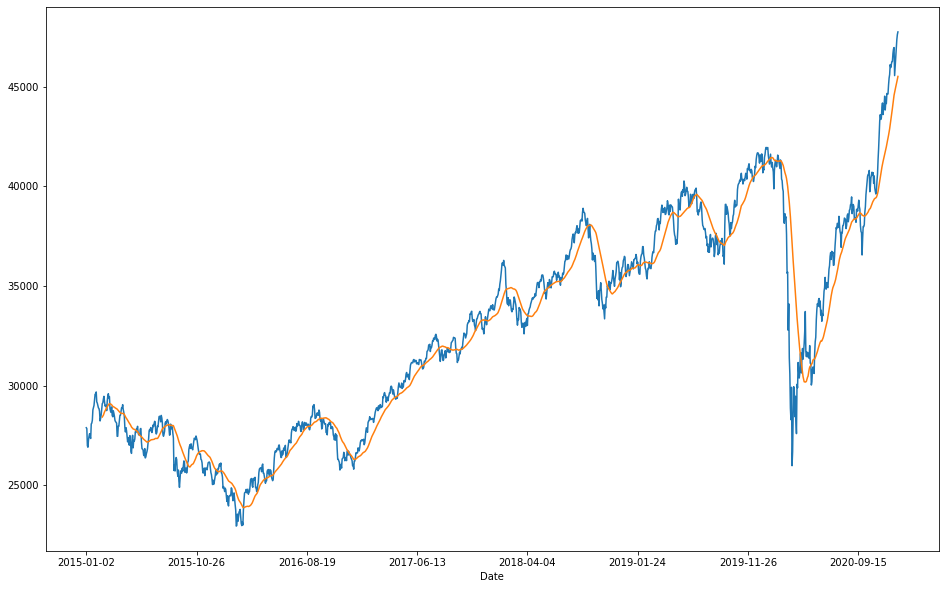

In [22]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting the close price and a 30-day rolling mean of close price
stock_data['Close'].plot()
stock_data.rolling(window=30).mean()['Close'].plot()

In [23]:
# displaying stock_data
stock_data

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2015-01-02,27887.900391,-0.9995,0.130,0.767,0.102,27521.279297,27937.470703,27519.259766,7400.0
2015-01-05,27842.320312,-0.9972,0.117,0.776,0.107,27978.429688,28064.490234,27786.849609,9200.0
2015-01-06,26987.460938,-0.9994,0.097,0.838,0.065,27694.230469,27698.929688,26937.060547,14100.0
2015-01-07,26908.820312,-0.9999,0.146,0.775,0.079,26983.429688,27051.599609,26776.119141,12200.0
2015-01-08,27274.710938,-0.9999,0.131,0.803,0.066,27178.769531,27316.410156,27101.939453,8200.0
...,...,...,...,...,...,...,...,...,...
2020-12-23,46444.179688,-0.9995,0.117,0.804,0.078,46072.300781,46513.320312,45899.101562,10500.0
2020-12-24,46973.539062,-0.9966,0.080,0.857,0.063,46743.488281,47053.398438,46539.019531,13700.0
2020-12-28,47353.750000,-0.9997,0.125,0.792,0.083,47153.589844,47406.718750,47148.238281,9600.0


# 8 Data Preparation for Modelling

In [24]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 1177
Number of records in Test Data: 296


In [25]:
# predicting one step ahead
steps_to_predict = 1

# capturing data to be used for each column
close_price = stock_data.iloc[start:total_data,0] #close
compound = stock_data.iloc[start:total_data,1] #compound
negative = stock_data.iloc[start:total_data,2] #neg
neutral = stock_data.iloc[start:total_data,3] #neu
positive = stock_data.iloc[start:total_data,4] #pos
open_price = stock_data.iloc[start:total_data,5] #open
high = stock_data.iloc[start:total_data,6] #high
low = stock_data.iloc[start:total_data,7] #low
volume = stock_data.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
close_price

Close Price:


Date
2015-01-05    27842.320312
2015-01-06    26987.460938
2015-01-07    26908.820312
2015-01-08    27274.710938
2015-01-09    27458.380859
                  ...     
2020-12-23    46444.179688
2020-12-24    46973.539062
2020-12-28    47353.750000
2020-12-29    47613.078125
2020-12-30    47746.218750
Name: Close, Length: 1472, dtype: float64

In [26]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,,
2015-01-05,27842.320312,26987.460938,-0.9972,-0.9994,9200.0,27978.429688,28064.490234,27786.849609
2015-01-06,26987.460938,26908.820312,-0.9994,-0.9999,14100.0,27694.230469,27698.929688,26937.060547
2015-01-07,26908.820312,27274.710938,-0.9999,-0.9999,12200.0,26983.429688,27051.599609,26776.119141
2015-01-08,27274.710938,27458.380859,-0.9999,-0.9998,8200.0,27178.769531,27316.410156,27101.939453
2015-01-09,27458.380859,27585.269531,-0.9998,0.9977,11100.0,27404.189453,27507.669922,27119.630859
2015-01-12,27585.269531,27425.730469,0.9977,-0.9992,7500.0,27523.859375,27620.660156,27323.740234
2015-01-13,27425.730469,27346.820312,-0.9992,-0.9996,7800.0,27611.560547,27670.189453,27324.580078
2015-01-14,27346.820312,28075.550781,-0.9996,-0.9994,10200.0,27432.140625,27512.800781,27203.250000
2015-01-15,28075.550781,28121.890625,-0.9994,-0.9994,16700.0,27831.160156,28194.609375,27703.699219


# 9 Setting the Target Variable and the Feature Dataset

In [27]:
# setting the target variable as the shifted close_price
y = data['close_price_shifted']
y

Date
2015-01-05    26987.460938
2015-01-06    26908.820312
2015-01-07    27274.710938
2015-01-08    27458.380859
2015-01-09    27585.269531
                  ...     
2020-12-22    46444.179688
2020-12-23    46973.539062
2020-12-24    47353.750000
2020-12-28    47613.078125
2020-12-29    47746.218750
Name: close_price_shifted, Length: 1471, dtype: float64

In [28]:
# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,
2015-01-05,27842.320312,-0.9972,-0.9994,9200.0,27978.429688,28064.490234,27786.849609
2015-01-06,26987.460938,-0.9994,-0.9999,14100.0,27694.230469,27698.929688,26937.060547
2015-01-07,26908.820312,-0.9999,-0.9999,12200.0,26983.429688,27051.599609,26776.119141
2015-01-08,27274.710938,-0.9999,-0.9998,8200.0,27178.769531,27316.410156,27101.939453
2015-01-09,27458.380859,-0.9998,0.9977,11100.0,27404.189453,27507.669922,27119.630859
...,...,...,...,...,...,...,...
2020-12-22,46006.691406,-0.9999,-0.9995,25100.0,45529.609375,46080.179688,45112.191406
2020-12-23,46444.179688,-0.9995,-0.9966,10500.0,46072.300781,46513.320312,45899.101562
2020-12-24,46973.539062,-0.9966,-0.9997,13700.0,46743.488281,47053.398438,46539.019531


### 9.1 Scaling the Target Variable and the Feature Dataset


In [29]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[-0.60338664, -0.99719986, -0.99939997, ..., -0.59698495,
         -0.59941304, -0.5743613 ],
        [-0.67271479, -0.99939997, -0.99989999, ..., -0.62027402,
         -0.62916777, -0.64270724],
        [-0.67909246, -0.99989999, -0.99989999, ..., -0.67852151,
         -0.68185708, -0.65565127],
        ...,
        [ 0.94813409, -0.99659983, -0.99969998, ...,  0.94074195,
          0.94618563,  0.93381837],
        [ 0.97896878, -0.99969998, -0.99969998, ...,  0.97434825,
          0.97494407,  0.98281597],
        [ 1.        , -0.99969998, -0.99969998, ...,  1.        ,
          1.        ,  1.        ]]), array([[-0.67447224],
        [-0.68081566],
        [-0.65130168],
        ...,
        [ 0.96834213],
        [ 0.98926042],
        [ 1.        ]]))

### 9.2 Dividing the dataset into Training and Test


In [30]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (1177, 7) and y: (1177, 1)
Number of rows and columns in the Test set X: (293, 7) and y: (293, 1)


### 9.3 Reshaping the Feature Dataset

In [31]:
# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (1177, 7, 1)
Shape of Test set X: (293, 7, 1)


# 10 Stock Data Modelling

In [32]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(2016)

# setting the model architecture
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 7, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 7, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [33]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=8, verbose=1)

Epoch 1/10
118/118 [==============================] - 10s 31ms/step - loss: 0.0563 - val_loss: 0.0610
Epoch 2/10
118/118 [==============================] - 2s 21ms/step - loss: 0.0261 - val_loss: 0.0548
Epoch 3/10
118/118 [==============================] - 2s 21ms/step - loss: 0.0119 - val_loss: 0.0069
Epoch 4/10
118/118 [==============================] - 2s 21ms/step - loss: 0.0028 - val_loss: 0.0049
Epoch 5/10
118/118 [==============================] - 2s 20ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 6/10
118/118 [==============================] - 2s 20ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 7/10
118/118 [==============================] - 2s 20ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 8/10
118/118 [==============================] - 2s 20ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 9/10
118/118 [==============================] - 2s 20ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 10/10
118/118 [==============================] - 2s 20ms/step - loss: 0.0017 - val_l

### 10.1 Saving the Model to disk

In [34]:
# saving the model as a json file
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights('model.h5')
print('Model is saved to the disk')

Model is saved to the disk


# 11 Predictions

In [35]:
# performing predictions
predictions = model.predict(X_test) 

# unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# printing the predictions
print('Predictions:')
predictions[0:5]

Predictions:


array([[39164.16 ],
       [39063.215],
       [39552.12 ],
       [40047.562],
       [40268.152]], dtype=float32)

# 12 Model Evaluation

In [36]:
# calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

293/293 [==============================] - 1s 4ms/step - loss: 0.0028
Train Loss = 0.0014
Test Loss = 0.0028


In [37]:
# calculating root mean squared error
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 38672.2948


In [38]:
# calculating root mean squared error using sklearn.metrics package
rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 38672.2948


# 13 Plotting the Predictions against unseen data

In [39]:
# unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

# unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

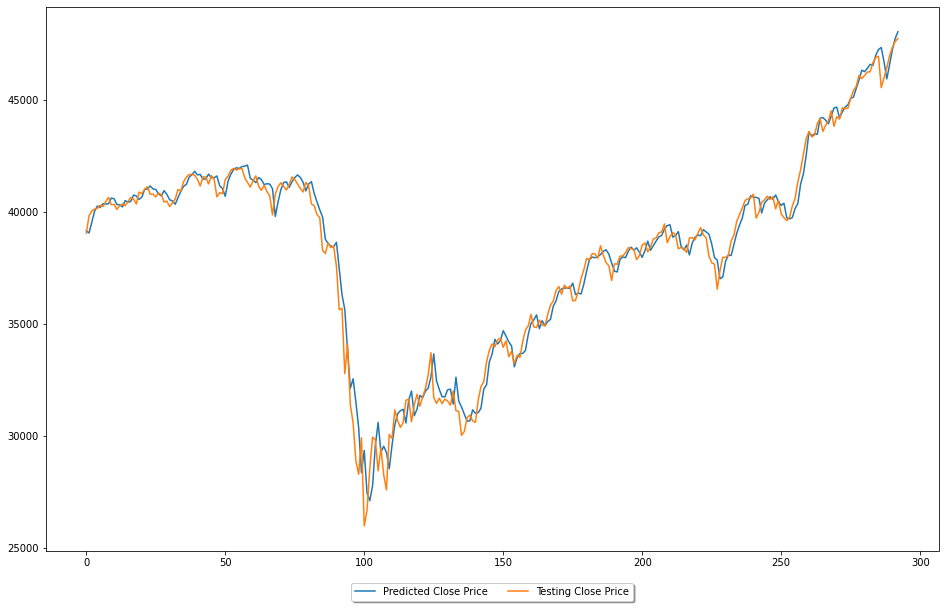

In [40]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()

# 14 References

[1] https://github.com/ZainUlMustafa/Stock-Prediction-using-News-Info-Sentiment/blob/master/modelling.ipynb <br>
[2] https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/

[3] (https://github.com/monica110394/Stock-Market-Prediction)
